# Text Encoder

In [1]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

Downloading: 100%|██████████| 28.0/28.0 [00:00<00:00, 14.0kB/s]
Downloading: 100%|██████████| 226k/226k [00:00<00:00, 1.42MB/s]
Downloading: 100%|██████████| 455k/455k [00:00<00:00, 1.60MB/s]
Downloading: 100%|██████████| 570/570 [00:00<00:00, 285kB/s]
Downloading: 100%|██████████| 420M/420M [00:06<00:00, 64.5MB/s] 
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from 

In [28]:
text = "Replace me by any text you'd like"
encoded_input = tokenizer(text, return_tensors='pt')
print(encoded_input)
output = model(**encoded_input)
print('x shape:', encoded_input['input_ids'].shape)
print('y shape:', output[0].shape)
print('pooled shape:', output[1].shape)

{'input_ids': tensor([[ 101, 5672, 2033, 2011, 2151, 3793, 2017, 1005, 1040, 2066,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
x shape: torch.Size([1, 11])
y shape: torch.Size([1, 11, 768])
pooled shape: torch.Size([1, 768])


# Audio Encoder
- All code for this can be found here: https://github.com/Daisyqk/Automatic-Prosody-Annotation/tree/master/code
- An additional helpful source: https://github.com/andabi/deep-voice-conversion
- mp3 to spectrogram conversion: https://www.pythonpool.com/spectrogram-python/

In [2]:
import pandas as pd
# load wav
filename = 'LJ001-0001'
wav_path ='../src/ProSS/LJSpeech-1.1/wavs/{}.wav'.format(filename)
df = pd.read_csv('../src/ProSS/LJSpeech-1.1/metadata.csv', sep='|', header=None)
df.columns = ['name','text','text2']
df.head()


,name,text,text2
0,LJ001-0001,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed...","produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...


In [3]:
text_l = df.loc[df['name'] == filename]['text'].item().lower()
print(text_l)

printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the exhibition


sample_rate:  22050
samples:  (212893,)


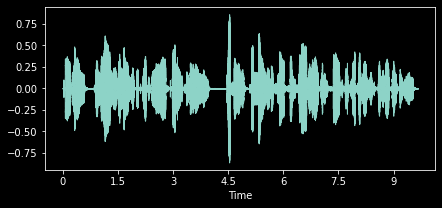

In [4]:
import librosa
import librosa.display

import IPython.display as ipd

import matplotlib.pyplot as plt

sample_rate = 22050

x, sr = librosa.load(wav_path, sr=sample_rate)
print('sample_rate: ', sr)
print('samples: ', x.shape)

plt.figure(figsize=(7, 3))
librosa.display.waveshow(x, sr=sr)


## Create PPG

In [147]:
from cProfile import label
from matplotlib.pyplot import tick_params
import numpy as np

PHONEME_LIST = {
    "pau":0,
    "aa":1,
    "ae":2,
    "ah":3,
    "ao":4,
    "aw":5,
    "ax":6,
    "axr":7,
    "ay":8,
    "b":9,
    "ch":10,
    "d":11,
    "dh":12,
    "dx":13,
    "eh":14,
    "ei":15,
    "er":16,
    "ey":17,
    "f":18,
    "fpm":19,
    "fpu":20,
    "g":21,
    "hh":22,
    "ih":23,
    "ix":24,
    "iy":25,
    "jh":26,
    "k":27,
    "l":28,
    "m":29,
    "n":30,
    "nx":31,
    "oh":32,
    "ow":33,
    "oy":34,
    "p":35,
    "r":36,
    "s":37,
    "sh":38,
    "sil":39,
    "t":40,
    "th":41,
    "uh":42,
    "uw":43,
    "v":44,
    "w":45,
    "y":46,
    "z":47,
    "zh":48
}


def create_PPG_from_arctic(labels):
    clip_len = int(float(labels[-1].split(' ')[0]) * 100)+1
    # init matrix
    PPG = np.array([[0 for y in range(clip_len)] for x in range(49)])
    
    page_idx = 1 # start at 1 so that I can skip the '#' at the begging of the file.
    my_idx = 0.00
    step = 0.01
    mat_idx = 0

    curr_end_dur = float(labels[page_idx+1].split(' ')[0])
    curr_phon = labels[page_idx].strip().split(' ')[-1]

    while(my_idx <= clip_len):
        # check to see if my_idx is <= curr_dur (or next maybe)
        if my_idx <= curr_end_dur:
            # append a 1 to position of matrix at [phoneme mapping, mat_idx]
            PPG[PHONEME_LIST[curr_phon], mat_idx] = 1
        else:
            page_idx += 1

            if page_idx+1 >= len(labels):
                curr_end_dur = float(clip_len) / 100.00
                curr_phon = labels[len(labels)-1].strip().split(' ')[-1]
            else:
                curr_end_dur = float(labels[page_idx+1].split(' ')[0])
                curr_phon = labels[page_idx].strip().split(' ')[-1]
        
        my_idx += step
        mat_idx += 1
    
    #fig, ax = plt.subplots(figsize=(96,48))
    #ax.set_yticks(list(PHONEME_LIST.values()), list(PHONEME_LIST.keys()))
    #ax.set_xticks(range(0,clip_len))
    #tick_params(labelright=True)
    #ax.grid()
    #ax.imshow(PPG)
    return PPG


    


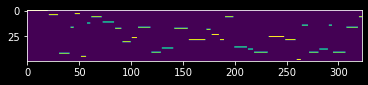

In [148]:
# cmu_arctic
cmu_path = '../src/ProSS/cmu_arctic/cmu_us_bdl_arctic'
cmu_filename = 'arctic_a0001'
cmu_sr = 16000

text = open("{}/etc/txt.done.data".format(cmu_path), "r").readlines()
audio = librosa.load("{}/wav/{}.wav".format(cmu_path, cmu_filename), sr=cmu_sr)
labels = open("{}/lab/{}.lab".format(cmu_path, cmu_filename), "r").readlines()

PPG = create_PPG_from_arctic(labels)
plt.imshow(PPG)

## Create PPG generative network

In [ ]:
import torch

# need to pad input data because of varying lengths

# define linear network that is capable of taking in audio to produce PPG.


## Use generative network on LJSpeech dataset

# Multi-modal Fusion decoder

## Audio half

In [ ]:
# self-attention
# feed-forward
# linear layer (output of this used in text half)

## Text half

In [ ]:
# cross-attention (with audio half out as input)
# feed-forward
# linear layer (this provides output prosody) / (this prosody output is what needs to be feature engineered & annotated)

# Temp Code

In [29]:
import torch
import torch.nn as nn
import copy
import math
from torch.autograd import Variable
import torch.nn.functional as F

# from Sublayers import Norm, FeedForward, MultiHeadAttention
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout = 0.1):
        super().__init__() 
    
        # We set d_ff as a default to 2048
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)
    
    def forward(self, x):
        x = self.dropout(F.relu(self.linear_1(x)))
        x = self.linear_2(x)
        return x
        
class Norm(nn.Module):
    def __init__(self, d_model, eps = 1e-6):
        super().__init__()
    
        self.size = d_model
        
        # create two learnable parameters to calibrate normalisation
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))
        
        self.eps = eps
    
    def forward(self, x):
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm

def attention(q, k, v, d_k, mask=None, dropout=None):
    # print('attention'+ str(k.size()))
    scores = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(d_k)
    
    if mask is not None:
        mask = mask.unsqueeze(1)
        # print('mask')
        # print(mask.size())
        # print('score')
        # print(scores.size())
        scores = scores.masked_fill(mask == 0, -1e9)
    
    scores = F.softmax(scores, dim=-1)
    
    if dropout is not None:
        scores = dropout(scores)
        
    output = torch.matmul(scores, v)
    return output, scores

class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout = 0.1):
        super().__init__()
        
        self.d_model = d_model
        self.d_k = d_model // heads
        self.h = heads
        
        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)
    
    def forward(self, q, k, v, mask=None):
        
        bs = q.size(0)
        # perform linear operation and split into N heads
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)  #5, 4213, 2688     5, ,8, 336
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)
        
        # transpose to get dimensions bs * N * sl * d_model
        k = k.transpose(1,2)
        q = q.transpose(1,2)
        v = v.transpose(1,2)
        

        # calculate attention using function we will define next
        scores, attention_map = attention(q, k, v, self.d_k, mask, self.dropout)
        # concatenate heads and put through final linear layer
        concat = scores.transpose(1,2).contiguous()\
        .view(bs, -1, self.d_model)
        output = self.out(concat)
    
        return output, attention_map

# from Layers import EncoderLayer
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.attn = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.ff = FeedForward(d_model, dropout=dropout)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)

    def forward(self, x, mask):
        x2 = self.norm_1(x)
        x3, _ = self.attn(x2, x2, x2, mask)
        x = x + self.dropout_1(x3)
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.ff(x2))
        return x

# from Embed import PositionalEncoder
class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_len, dropout = 0.1):
        super().__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(dropout)
        # create constant 'pe' matrix with values dependant on 
        # pos and i
        pe = torch.zeros(max_seq_len, d_model)
        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = \
                math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = \
                math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
 
    def forward(self, x):
        # make embeddings relatively larger
        x = x * math.sqrt(self.d_model)
        #add constant to embedding
        seq_len = x.size(1)
        pe = Variable(self.pe[:,:seq_len], requires_grad=False)
        if x.is_cuda:
            pe.cuda()
        x = x + pe
        return self.dropout(x)

def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

# found in models.py
class audio_Encoder(nn.Module):
    def __init__(self, d_mfcc, max_mfcc_length, N, heads, dropout):
        super().__init__()
        self.N = N
        self.pe = PositionalEncoder(d_model=d_mfcc, max_seq_len=max_mfcc_length,dropout=dropout)
        self.layers = get_clones(EncoderLayer(d_model=d_mfcc, heads=heads, dropout=dropout), N)
        self.norm = Norm(d_model=d_mfcc)

    def forward(self, src, audio_mask):
        x = self.pe(src)
        for i in range(self.N):
            x = self.layers[i](x, audio_mask)
        return self.norm(x)

In [ ]:
# opt.scp_path = data/features.scp
# opt.model_path = model.pth